In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



In [44]:
file = "heart_failure_clinical_records_dataset (1).csv"
df = pd.read_csv(file)

In [103]:
len(df)

299

# We're trying to predict whether someone will have a heart failure event

# Steps:

1 - normalise the non-binary data

2 - check the ordinal columns are just 1 and 0

3 - don't need to do label encoding because it's already one, but let's do it in reverse to demonstrate it

4 - check correlations between the different x variables

5 - create a stratified shuffle split to get the test set

6 - create the three logRes models

7 - create table comparing coefficients for each x value

8 - predict heart failure in the test data, and create scatter graphs of each 'proba' versus actual y

9 - compute recall, accuracy, fscore, roc and confusion matrix for each of the different models

In [25]:
#This will get all the columns where max is equal to.
df.loc[:,df.describe().loc['max'] == 1].describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.00000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,0.32107
std,0.496107,0.494067,0.478136,0.478136,0.46767,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


# the following X_columns seem to be binary
1) Anaemia, 2) Diabets, 3) High_blood_pressure, 4) sex, 5) smoking

In [28]:
#This gets the opposite
non_binary_cols = df.loc[:,df.describe().loc['max'] != 1].describe()
display(non_binary_cols)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


In [47]:
#Let's minmax() this data, otherwise we're going to struggle when we apply regularisation. also by using minmax,
'''we get a similar type of distribution as our binary sets'''
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
df_after_mms = df
df = pd.read_csv(file) #to ensure df stays the same.
df_after_mms[non_binary_cols.columns] = mms.fit_transform(df_after_mms[non_binary_cols.columns])

In [50]:
display(df_after_mms.describe())

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,0.378798,0.431438,0.071299,0.418060,0.364903,0.351171,0.288833,0.100436,0.675012,0.648829,0.32107,0.449327,0.32107
std,0.216269,0.496107,0.123793,0.494067,0.179316,0.478136,0.118565,0.116237,0.126071,0.478136,0.46767,0.276207,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,0.200000,0.000000,0.011929,0.000000,0.242424,0.000000,0.227179,0.044944,0.600000,0.000000,0.00000,0.245552,0.00000
50%,0.363636,0.000000,0.028961,0.000000,0.363636,0.000000,0.287186,0.067416,0.685714,1.000000,0.00000,0.395018,0.00000
75%,0.545455,1.000000,0.071319,1.000000,0.469697,1.000000,0.337495,0.101124,0.771429,1.000000,1.00000,0.708185,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000


# OK, just for fun, let's turn the death event into 'died, survived' and then use label encoding to turn them back

In [52]:
df_after_mms['death_wordy'] = df_after_mms['DEATH_EVENT'].apply(lambda x: "died" if x == 1 else 'Survived')

In [56]:
#OK, now let's use label encoding to turn it back
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_after_mms['death label'] = le.fit_transform(df_after_mms['death_wordy'])

#Great, we can now drop the initial column
df_after_mms.drop('DEATH_EVENT',axis=1,inplace=True)

# Now let's have a look at the correlations between the input variables

In [61]:
X_columns = df_after_mms.drop(['death label','death_wordy'],axis=1)

In [92]:
Y_column = df_after_mms['death label']

In [91]:
x_corr = X_columns.corr()
#We have this horrible situation with the layout, so we need to remove all the trill indices and re-formt
trills = np.tril_indices_from(x_corr)
#convert to array so we can use the trills to remove the values
x_corr_array = np.array(x_corr)
x_corr_array[trills] = np.nan
corr_df = pd.DataFrame(x_corr_array,columns = x_corr.columns,index = x_corr.index
                      ).stack().to_frame(
                      ).reset_index().rename(columns =
                       {'level_0':'feature_1',
                       'level_1': 'feature_2',
                       0: 'correlation'}).sort_values('correlation'
                                                     ,ascending=False)
pd.set_option('display.max_rows', None)
display(corr_df,)

,feature_1,feature_2,correlation
63,sex,smoking,0.445892
41,ejection_fraction,serum_sodium,0.175902
6,age,serum_creatinine,0.159187
4,age,high_blood_pressure,0.093289
32,diabetes,platelets,0.092193
0,age,anaemia,0.088006
62,serum_sodium,time,0.087640
27,creatinine_phosphokinase,sex,0.079791
39,ejection_fraction,platelets,0.072177
8,age,sex,0.065430


Other than Sex <-> Smoking, the correlations are relatively ligh 

# OK, now let's get a stratified shuffle split specifically for test data

this just gets x_train and x_train (and y), with a similar distribution of dependent variable in each

In [94]:
from sklearn.model_selection import StratifiedShuffleSplit

In [104]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
sss.get_n_splits(X_columns,Y_column)

1

In [105]:
train_index, test_index = next(sss.split(X_columns,Y_column))

X_train = X_columns.loc[train_index]
Y_train = Y_column.loc[train_index]

#so here we create the x and y for one instance of the sss

X_test = X_columns.loc[test_index]
Y_test = Y_column.loc[test_index]

In [106]:
X_test.shape

(75, 12)

# Now we will make the three different LogisticRegression models

In [111]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

In [218]:
#initially, let's just create a simple logisticRegression model
lr = LogisticRegression(solver='liblinear').fit(X_train,Y_train)
#then let's create them with l1 and l2 regularisation with 4 validation sets, and a 1/lambda value of 10
lr_l1 = LogisticRegressionCV(Cs = 10, cv = 4, penalty='l1',solver='liblinear').fit(X_train,Y_train) 
lr_l2 = LogisticRegressionCV(Cs = 10, cv = 4, penalty='l2',solver='liblinear').fit(X_train,Y_train)

Let's compare the coefficients

In [219]:
mods = [lr,lr_l1,lr_l2]
labels = ['lr','lr_l1','lr_l2']

coeffs_table = pd.DataFrame(columns = X_train.columns)
for mod in mods:
    coeffs_table = coeffs_table.append(pd.DataFrame(mod.coef_,columns = X_train.columns))

coeffs_table['model'] = labels
coeffs_table = coeffs_table.set_index('model')
#for mod, label in zip(mods,labels):
display(coeffs_table)    

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
model,,,,,,,,,,,,
lr,1.157184,0.128068,0.692057,-0.080406,-2.408222,-0.076962,-0.263471,1.883945,-0.434204,-0.381634,0.033371,-3.220792
lr_l1,1.377774,0.000000,1.109726,-0.053365,-5.507371,-0.198165,-0.861488,5.099441,-0.653826,-0.815411,0.000000,-5.237625
lr_l2,1.414087,0.082430,1.148803,-0.097856,-3.723429,-0.165667,-0.660708,3.108256,-0.747863,-0.620840,0.042122,-4.170433



And let's see how these do versus the real y's if we look at a scatter

In [298]:
import matplotlib.pyplot as plt

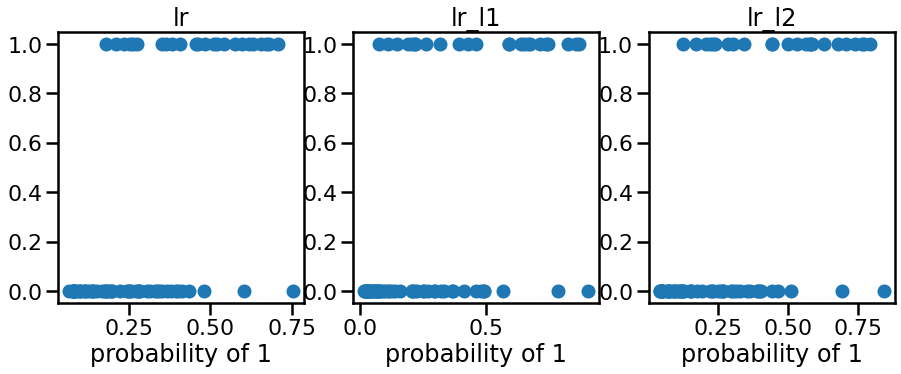

In [302]:
sns.set_context('poster')
fig, axList = plt.subplots(nrows =1, ncols=3,figsize = (15,5))

ax_n = 0
for mod,label in zip(mods,labels):
    axList[ax_n].scatter(mod.predict_proba(X_test)[:,1],Y_test)
    axList[ax_n].set_title(label)
    axList[ax_n].set_xlabel('probability of 1')

    ax_n+=1

# At a glance, lr or lr_l2 are likely to be the best. although lr has quite a few false negatives, and slightly less false positive (so it's more cautious

Now let's have a look at the precision, re-call, accuracy, f_score and confusion matric 


In [237]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [278]:
stats_scores = pd.DataFrame(columns = ['model','accuracy','precision','recall','AUC'])

for mod,label in zip(mods,labels):
    X_preds = mod.predict(X_test)
    
    accuracy = accuracy_score(Y_test,X_preds)
    precision = precision_score(Y_test,X_preds)
    recall = recall_score(Y_test,X_preds)
    auc = roc_auc_score(Y_test,X_preds)
    
    stats = pd.Series([label,accuracy,precision,recall,auc],index=stats_scores.columns)
    
    stats_scores = stats_scores.append(stats,ignore_index = True)
    
display(stats_scores)

,model,accuracy,precision,recall,AUC
0,lr,0.8,0.846154,0.458333,0.709559
1,lr_l1,0.8,0.800000,0.500000,0.720588
2,lr_l2,0.8,0.800000,0.500000,0.720588


# So lr has better precision (more of the predicted positives actually are positive) but has lower recall, and ultimately a lower AUC curve
Let's take a look at the confusion matrixes

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

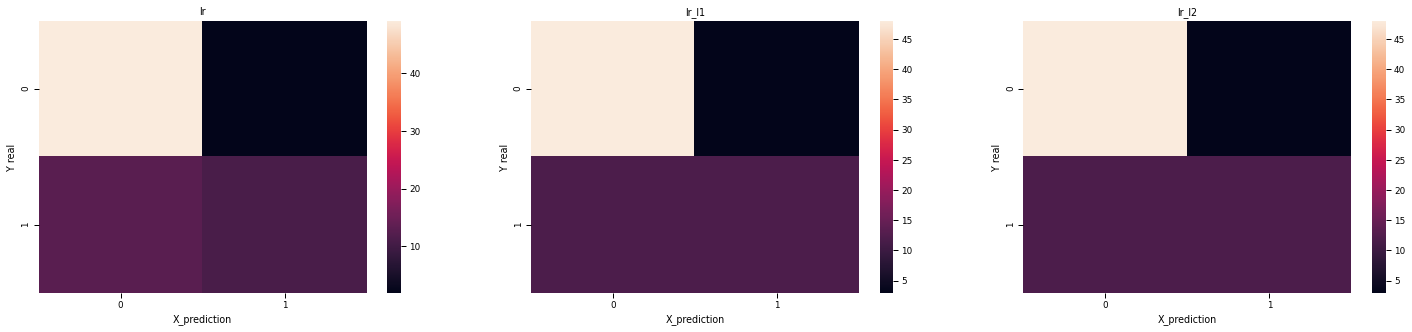

In [308]:
sns.set_context('paper')
import matplotlib.pyplot as plt2
fig1, axList1 = plt2.subplots(nrows =1, ncols=3,figsize = (25,5))

for mod,label,ax in zip(mods,labels,axList1):
    X_preds = mod.predict(X_test)
    CM = confusion_matrix(Y_test,X_preds)
    ax = sns.heatmap(CM,ax = ax)
    ax.set(title = label)
    ax.set()
    ax.set_xlabel('X_prediction')
    ax.set_ylabel('Y real')
plt.tight_layout

so very low rate of Y-pred = 0 and x_pred = 1 which makes sense because the precision is high.